# Import needed libraries
To make things work ensure that you have this libraries installed.

In [4]:
import os
import numpy as np
import splitfolders
import seaborn as sns
import tensorflow as tf
from string import digits
from imutils import paths
from random import choices
from typing import Tuple, List
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.data import AUTOTUNE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import GRU, Dense, Bidirectional, InputLayer, Reshape

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1,l2

2024-04-10 18:40:56.012819: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 18:40:56.012939: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 18:40:56.289613: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data
The **Dataset** class is designed as a helper tool for loading and preparing image datasets for training machine learning models.

In [5]:
class Dataset:
    def __init__(self, path: str, output: str | None = None, ratio: Tuple[float, float, float] = (.70, .15, .15), split: bool = True, image_size: Tuple[int, int] = (224,224), batch_size: int = 8):
        self.path = path
        self.labels = [name for name in os.listdir(self.path) if os.path.isdir(os.path.join(self.path, name))]

        self.ratio = ratio
        
        self.output_path = output if output else f"./data-{''.join(choices(digits, k=5))}"
        
        self.train = os.path.sep.join([self.output_path, 'train'])
        self.val = os.path.sep.join([self.output_path, 'val'])
        self.test = os.path.sep.join([self.output_path, 'test'])
        
        self.image_size = image_size
        self.batch_size = batch_size
        
        if split:
            self.__split_folder()
            
        self.__generate()
        
    def __split_folder(self):
        splitfolders.ratio(self.path, output=self.output_path, seed=42, ratio=self.ratio, group_prefix=None)
    
    def __generate(self):
        def load_images(image_path):
            image = tf.io.read_file(image_path)
            image = tf.image.decode_png(image, channels=3)
            image = tf.image.convert_image_dtype(image, dtype=tf.float32)
            image = tf.image.resize(image, self.image_size)
            
            label = tf.strings.split(image_path, os.path.sep)[-2]
            label = tf.cast(tf.equal(self.labels, label), tf.int32)
    
            return (image, label)
        
        train_paths = list(paths.list_images(self.train))
        self.train_len = len(train_paths) // self.batch_size
        self.train = tf.data.Dataset.from_tensor_slices(train_paths)
        self.train = (self.train
            .shuffle(len(train_paths), reshuffle_each_iteration=True)
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(self.batch_size)
            .repeat(-1)
            .prefetch(AUTOTUNE)
        )
        
        val_paths = list(paths.list_images(self.val))
        self.val_len = len(val_paths)// self.batch_size
        self.val = tf.data.Dataset.from_tensor_slices(val_paths)
        self.val = (self.val
            .shuffle(len(val_paths))
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(self.batch_size)
            .repeat(-1)
            .prefetch(AUTOTUNE)
        )
        
        test_paths = list(paths.list_images(self.test))
        self.test_len = len(test_paths)
        self.test = tf.data.Dataset.from_tensor_slices(test_paths)
        self.test = (self.test
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(self.batch_size)
            .prefetch(AUTOTUNE)
        )

# Helper functions
The following functions are helpful tools for visualising model training progress and evaluating model performance through confusion matrix analysis.

In [7]:
def plot_history(history, metric: str = '', ylim: List[float] | None = None):
    h = history.history
    plt.figure(figsize=(15,5))
    plt.plot(h[metric])
    plt.plot(h[f'val_{metric}'])
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend([metric, f'val_{metric}'], loc='upper left')
    if ylim:
        axes = plt.gca()
        axes.set_ylim(ylim)
    plt.show()
    
def show_confusion_matrix(y_true, y_pred, labels: List[str] = []):
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(labels), len(labels)))
    hm = sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.yticks(rotation = 0)
    hm.set_ylim(0, len(matrix))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# STFT

In [8]:
batch_size = 32
dataset = Dataset(path='/kaggle/input/musicgenreprediction/Data/images_augmented/stft', batch_size=batch_size)
train_stft, val_stft, test_stft = dataset.train, dataset.val, dataset.test

Copying files: 4995 files [00:51, 97.64 files/s] 


In [11]:
def conv_block(input_tensor, filters, kernel_size, strides=(1, 1), padding='same'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, kernel_initializer=he_normal())(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def identity_block(input_tensor, filters, kernel_size, strides=(1, 1), padding='same'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, kernel_initializer=he_normal())(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, strides=(1, 1), padding=padding, kernel_initializer=he_normal())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

def ResNet18(input_shape=(224, 224, 3), num_classes=1000):
    input_tensor = tf.keras.Input(shape=input_shape)

    x = conv_block(input_tensor, 64, (7, 7), strides=(2, 2))
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = identity_block(x, 64, (3, 3))
    x = identity_block(x, 64, (3, 3))

    x = conv_block(x, 128, (3, 3), strides=(2, 2))
    x = identity_block(x, 128, (3, 3))
    x = identity_block(x, 128, (3, 3))

    x = conv_block(x, 256, (3, 3), strides=(2, 2))
    x = identity_block(x, 256, (3, 3))
    x = identity_block(x, 256, (3, 3))

    x = conv_block(x, 512, (3, 3), strides=(2, 2))
    x = identity_block(x, 512, (3, 3))
    x = identity_block(x, 512, (3, 3))

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax', kernel_regularizer = l1(0.05))(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=x)
    return model

num_classes = 10

model = ResNet18(input_shape=(224, 224, 3), num_classes=num_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

epochs = 30

history = model.fit(dataset.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset.train_len,
                    validation_data=dataset.val,
                    validation_steps=dataset.val_len,
                    verbose=1)
#                     callbacks = [early_stopping])

model.summary()


Epoch 1/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 36s 146ms/step - accuracy: 0.4430 - loss: 12.4096 - val_accuracy: 0.1753 - val_loss: 8.3650
Epoch 2/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step - accuracy: 0.7161 - loss: 2.7099 - val_accuracy: 0.2106 - val_loss: 3.1541
Epoch 3/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.7726 - loss: 1.3095 - val_accuracy: 0.4561 - val_loss: 2.3748
Epoch 4/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.8142 - loss: 1.1591 - val_accuracy: 0.1646 - val_loss: 5.0160
Epoch 5/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.8571 - loss: 1.0036 - val_accuracy: 0.1367 - val_loss: 8.0717
Epoch 6/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.8845 - loss: 0.9104 - val_accuracy: 0.1534 - val_loss: 7.0873
Epoch 7/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.9139 - loss: 0.8049 - val_accuracy: 0.4324 - val_loss: 2.6043
Epoch 8/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.9304 - loss: 

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_56       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 56, 56,    │          0 │ activation_56[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 56, 56,    │     36,928 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_57       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_57[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_58       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 56, 56,    │          0 │ activation_58[0]… │
│                     │ 64)               │            │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_59       │ (None, 56, 56,    │          0 │ add_16[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_59[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_60       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_60[0]

 Total params: 42,342,560 (161.52 MB)

 Trainable params: 14,110,986 (53.83 MB)

 Non-trainable params: 9,600 (37.50 KB)

 Optimizer params: 28,221,974 (107.66 MB)

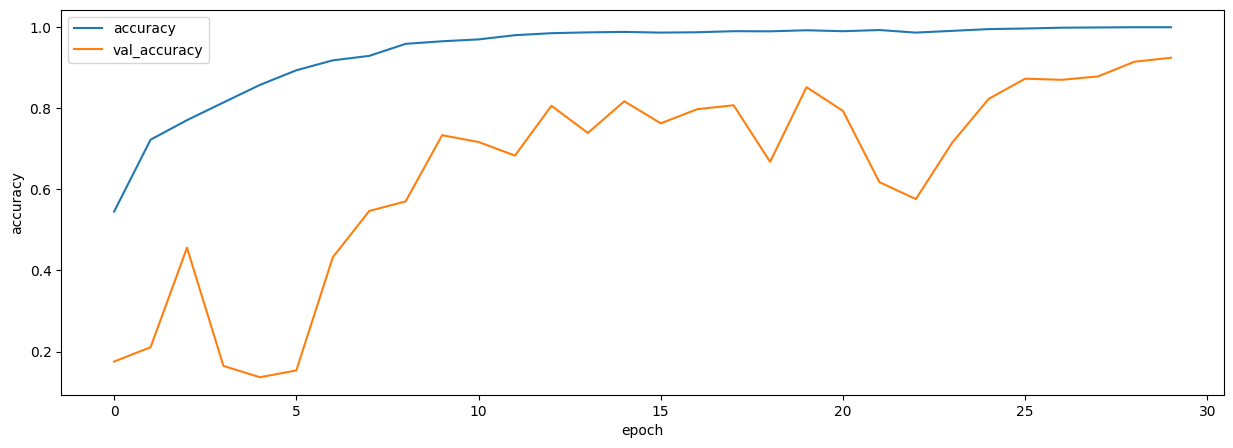

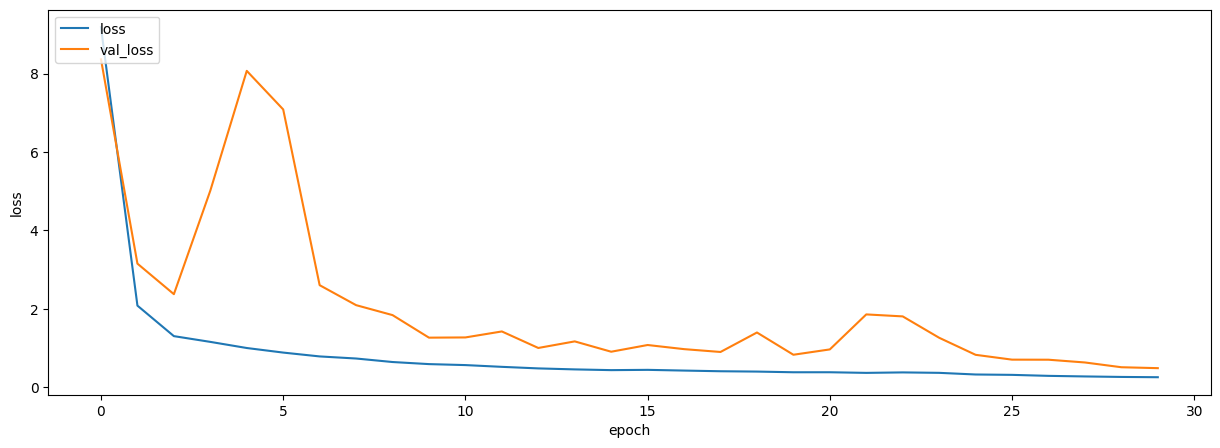

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.9530 - loss: 0.3763


W0000 00:00:1712775856.613432     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Accuracy: 0.937333345413208
Loss: 0.4285389184951782
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step


W0000 00:00:1712775860.567624     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


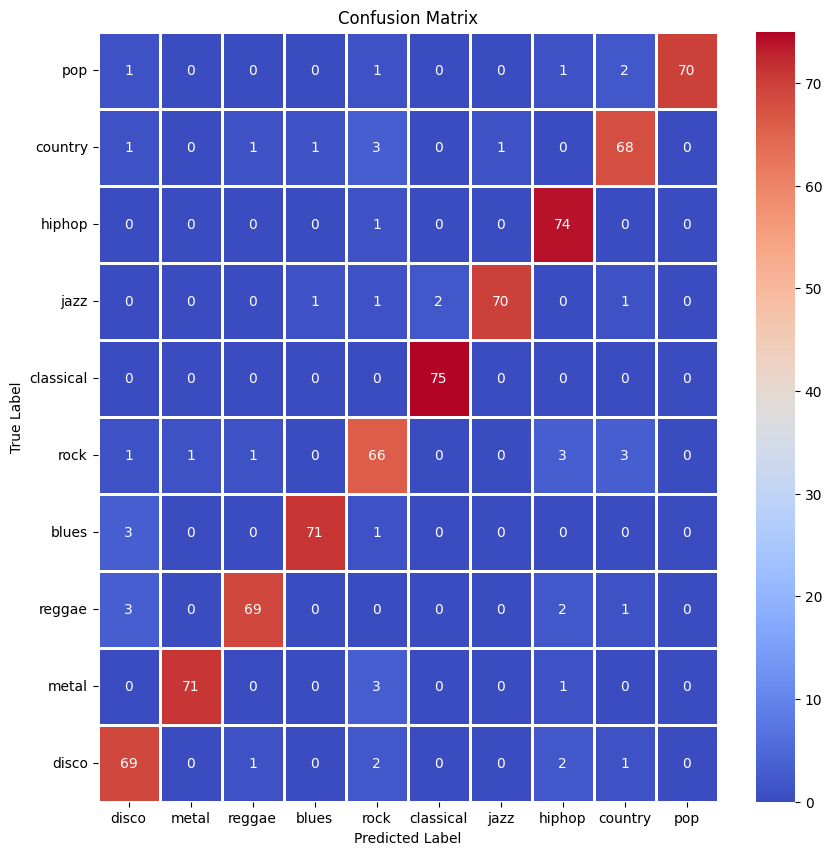

              precision    recall  f1-score   support

           0       0.88      0.92      0.90        75
           1       0.99      0.95      0.97        75
           2       0.96      0.92      0.94        75
           3       0.97      0.95      0.96        75
           4       0.85      0.88      0.86        75
           5       0.97      1.00      0.99        75
           6       0.99      0.93      0.96        75
           7       0.89      0.99      0.94        75
           8       0.89      0.91      0.90        75
           9       1.00      0.93      0.97        75

    accuracy                           0.94       750
   macro avg       0.94      0.94      0.94       750
weighted avg       0.94      0.94      0.94       750



In [12]:
plot_history(history, metric="accuracy")
plot_history(history, metric="loss")


evaluation = model.evaluate(test_stft, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')


y_pred = model.predict(test_stft)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in test_stft], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))

# Mel - Spectrogram

In [13]:
batch_size = 32
dataset_mel = Dataset(path='/kaggle/input/musicgenreprediction/Data/images_augmented/mel_spectrogram', batch_size=batch_size)
train_mel, val_mel, test_mel = dataset_mel.train, dataset_mel.val, dataset_mel.test

Copying files: 4995 files [00:49, 101.39 files/s]


In [14]:
def conv_block(input_tensor, filters, kernel_size, strides=(1, 1), padding='same'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, kernel_initializer=he_normal())(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def identity_block(input_tensor, filters, kernel_size, strides=(1, 1), padding='same'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, kernel_initializer=he_normal())(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, strides=(1, 1), padding=padding, kernel_initializer=he_normal())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

def ResNet18(input_shape=(224, 224, 3), num_classes=1000):
    input_tensor = tf.keras.Input(shape=input_shape)

    x = conv_block(input_tensor, 64, (7, 7), strides=(2, 2))
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = identity_block(x, 64, (3, 3))
    x = identity_block(x, 64, (3, 3))

    x = conv_block(x, 128, (3, 3), strides=(2, 2))
    x = identity_block(x, 128, (3, 3))
    x = identity_block(x, 128, (3, 3))

    x = conv_block(x, 256, (3, 3), strides=(2, 2))
    x = identity_block(x, 256, (3, 3))
    x = identity_block(x, 256, (3, 3))

    x = conv_block(x, 512, (3, 3), strides=(2, 2))
    x = identity_block(x, 512, (3, 3))
    x = identity_block(x, 512, (3, 3))

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax',  kernel_regularizer = l1(0.05))(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=x)
    return model

num_classes = 10  

model = ResNet18(input_shape=(224, 224, 3), num_classes=num_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

epochs = 30

history = model.fit(dataset_mel.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset_mel.train_len,
                    validation_data=dataset_mel.val,
                    validation_steps=dataset_mel.val_len,
                    verbose=1)
#                     callbacks = [early_stopping])

model.summary()

Epoch 1/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 37s 151ms/step - accuracy: 0.3508 - loss: 12.8731 - val_accuracy: 0.2038 - val_loss: 9.7660
Epoch 2/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step - accuracy: 0.5726 - loss: 3.3211 - val_accuracy: 0.2245 - val_loss: 3.1227
Epoch 3/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.6408 - loss: 1.6106 - val_accuracy: 0.4951 - val_loss: 2.0496
Epoch 4/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.7023 - loss: 1.4232 - val_accuracy: 0.4310 - val_loss: 2.3634
Epoch 5/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.7399 - loss: 1.2944 - val_accuracy: 0.2650 - val_loss: 4.3298
Epoch 6/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.7883 - loss: 1.1615 - val_accuracy: 0.5649 - val_loss: 1.8014
Epoch 7/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.8224 - loss: 1.0799 - val_accuracy: 0.5035 - val_loss: 2.1084
Epoch 8/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.8447 - loss: 

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_60[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_84       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 56, 56,    │          0 │ activation_84[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 56, 56,    │     36,928 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_61[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_85       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_85[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_62[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_86       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 56, 56,    │          0 │ activation_86[0]… │
│                     │ 64)               │            │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_87       │ (None, 56, 56,    │          0 │ add_24[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_87[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_63[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_88       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_88[0]

 Total params: 42,342,560 (161.52 MB)

 Trainable params: 14,110,986 (53.83 MB)

 Non-trainable params: 9,600 (37.50 KB)

 Optimizer params: 28,221,974 (107.66 MB)

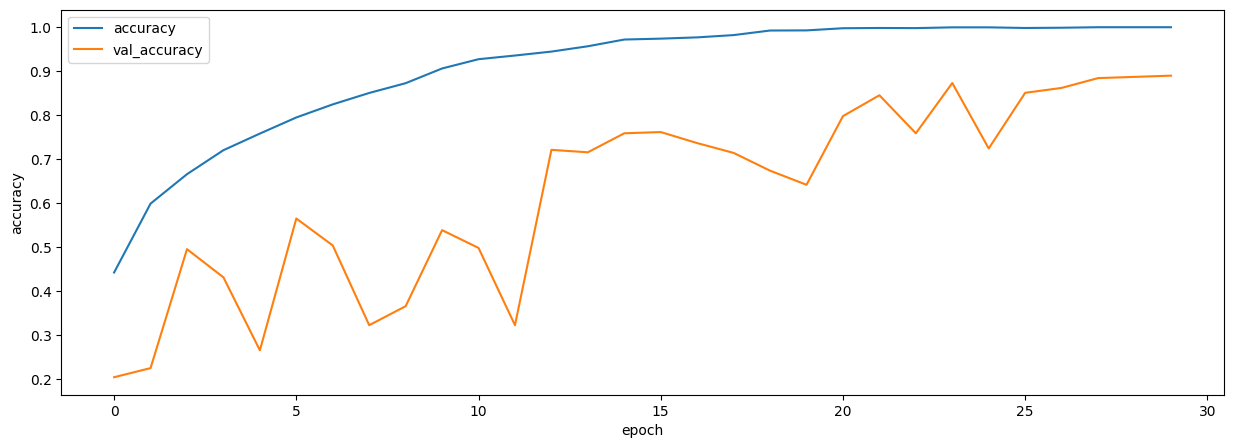

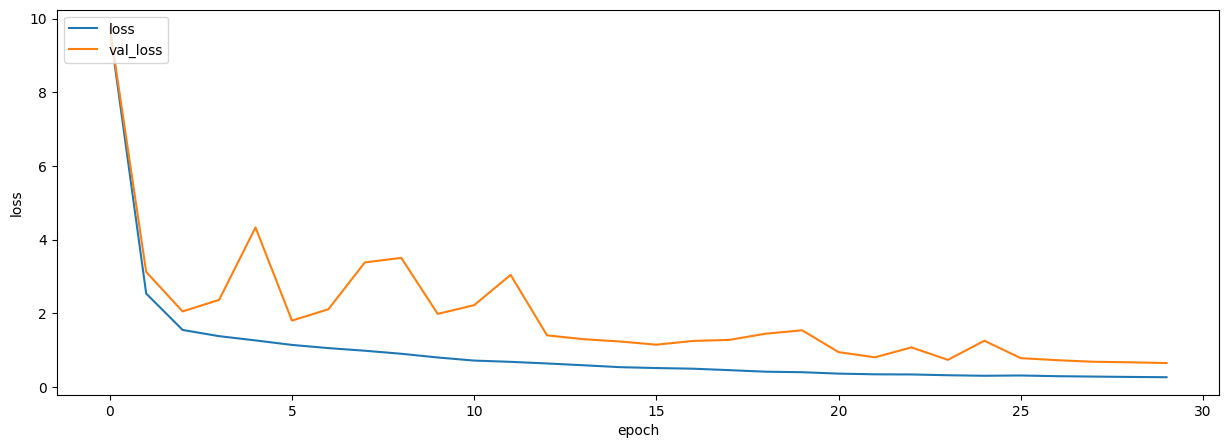

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9347 - loss: 0.4392


W0000 00:00:1712776562.808347     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Accuracy: 0.9160000085830688
Loss: 0.506722629070282
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step


W0000 00:00:1712776566.439855     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


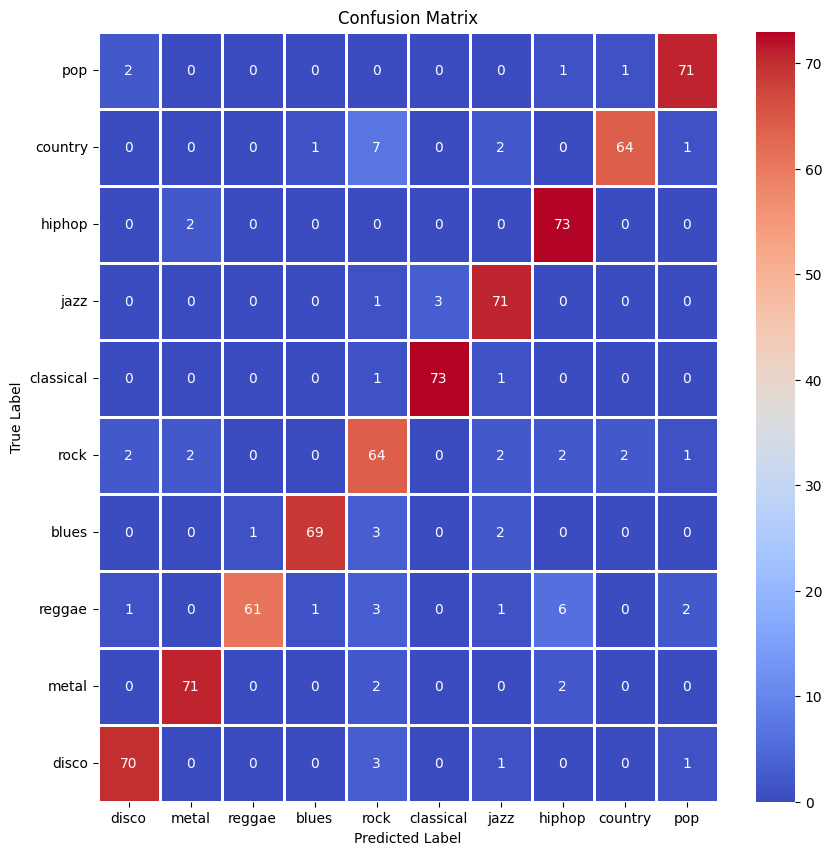

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        75
           1       0.95      0.95      0.95        75
           2       0.98      0.81      0.89        75
           3       0.97      0.92      0.95        75
           4       0.76      0.85      0.81        75
           5       0.96      0.97      0.97        75
           6       0.89      0.95      0.92        75
           7       0.87      0.97      0.92        75
           8       0.96      0.85      0.90        75
           9       0.93      0.95      0.94        75

    accuracy                           0.92       750
   macro avg       0.92      0.92      0.92       750
weighted avg       0.92      0.92      0.92       750



In [15]:
plot_history(history, metric="accuracy")
plot_history(history, metric="loss")


evaluation = model.evaluate(test_mel, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')


y_pred = model.predict(test_mel)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in test_mel], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))